# Import libraries

In [82]:
from metric_functions import dice_score, iou_score, nc_ratio_error
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns
from skimage.morphology import binary_opening,binary_closing,disk


# Load Data

In [83]:
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]
no_nucleus=(labels==2).sum(axis=(1,2))==0
images=images[~no_nucleus]
labels=labels[~no_nucleus]

X_train_val,X_test,Y_train_val,Y_test=train_test_split(images,labels,test_size=0.2,stratify=labels.mean((1,2))>=np.median(labels.mean((1,2))),random_state=42)
X_train,X_val,Y_train,Y_val=train_test_split(X_train_val,Y_train_val,test_size=0.2,stratify=Y_train_val.mean((1,2))>=np.median(Y_train_val.mean((1,2))),random_state=42)

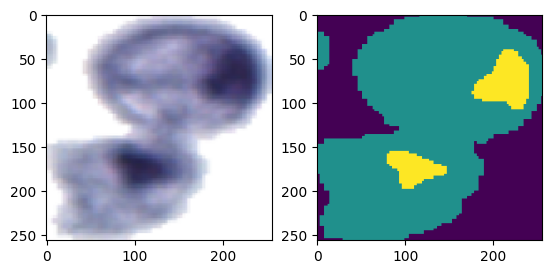

In [84]:
idx=2
plt.subplot(1,2,1)
plt.imshow(X_train[idx])
plt.subplot(1,2,2)
plt.imshow(Y_train[idx])

# Convert all images to Grayscale

In [85]:
X_train_gray=[]
for each_image in X_train:
    X_train_gray.append(rgb2gray(each_image/255.))
X_train_gray=np.array(X_train_gray)
X_val_gray=np.array([rgb2gray(x/255.) for x in X_val])
X_test_gray=np.array([rgb2gray(x/255.) for x in X_test])

In [86]:
# X_train #_gray#.mean(axis=0)

Another way to do this:

In [87]:
X_train_gray=np.vectorize(rgb2gray, signature='(w,h,3)->(w,h)')(X_train.astype(float)/255.)
X_val_gray=np.vectorize(rgb2gray, signature='(w,h,3)->(w,h)')(X_val.astype(float)/255.)
X_test_gray=np.vectorize(rgb2gray, signature='(w,h,3)->(w,h)')(X_test.astype(float)/255.)

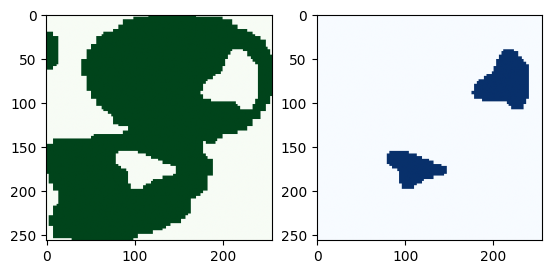

In [88]:
plt.subplot(121)
plt.imshow(Y_train[idx]==1,cmap="Greens")
plt.subplot(122)
plt.imshow(Y_train[idx]==2,cmap="Blues")

## Calculate True NC Ratios

In [89]:
Y_train #[0]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [90]:
# nucleus_train_true
# nc_ratio_train_true

In [91]:
nucleus_train_true=[]
for seg_mask in Y_train:
    nucleus_train_true.append((seg_mask==2).sum())
nucleus_train_true=np.array(nucleus_train_true)
nucleus_train_true=(Y_train.reshape(Y_train.shape[0],-1)==2).sum(axis=1)
cytoplasm_train_true=(Y_train.reshape(Y_train.shape[0],-1)==1).sum(axis=1)
nc_ratio_train_true=nucleus_train_true/(nucleus_train_true+cytoplasm_train_true)

nucleus_val_true=(Y_val.reshape(Y_val.shape[0],-1)==2).sum(axis=1)
cytoplasm_val_true=(Y_val.reshape(Y_val.shape[0],-1)==1).sum(axis=1)
nc_ratio_val_true=nucleus_val_true/(nucleus_val_true+cytoplasm_val_true)

nucleus_test_true=(Y_test.reshape(Y_test.shape[0],-1)==2).sum(axis=1)
cytoplasm_test_true=(Y_test.reshape(Y_test.shape[0],-1)==1).sum(axis=1)
nc_ratio_test_true=nucleus_test_true/(nucleus_test_true+cytoplasm_test_true)

## Practice Selecting Thresholds for NC Ratio Calculation

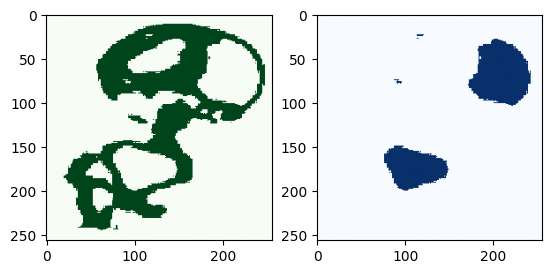

In [92]:
nucleus_threshold=0.4
nucleus_mask=X_train_gray[idx]<=nucleus_threshold

cytoplasm_threshold=0.6
cytoplasm_mask=np.logical_and(X_train_gray[idx]>=nucleus_threshold,X_train_gray[idx]<=cytoplasm_threshold)

plt.subplot(121)
plt.imshow(cytoplasm_mask,cmap="Greens")
plt.subplot(122)
plt.imshow(nucleus_mask,cmap="Blues")

Try a new threshold:

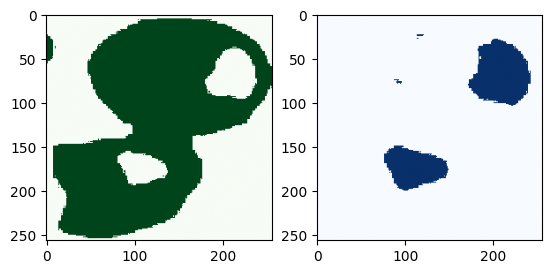

In [93]:
nucleus_threshold=0.3
cytoplasm_threshold=0.8
cytoplasm_mask=np.logical_and(X_train_gray[idx]>=nucleus_threshold,X_train_gray[idx]<=cytoplasm_threshold)

plt.subplot(121)
plt.imshow(cytoplasm_mask,cmap="Greens")
plt.subplot(122)
plt.imshow(nucleus_mask,cmap="Blues")

## Clean up the mask with morphological operations

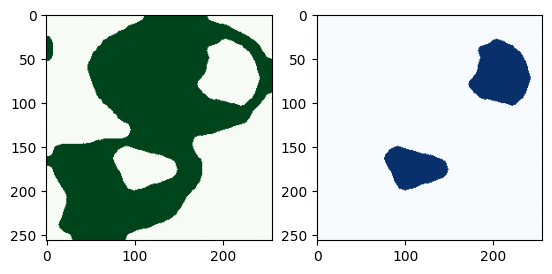

In [94]:
nucleus_threshold=0.4
opening_size=5
closing_size=8
nucleus_mask=X_train_gray[idx]<=nucleus_threshold
nucleus_mask=binary_opening(nucleus_mask,disk(opening_size))
nucleus_mask=binary_closing(nucleus_mask,disk(closing_size))

cytoplasm_threshold=0.8
cytoplasm_mask=X_train_gray[idx]<=cytoplasm_threshold
cytoplasm_mask=binary_opening(cytoplasm_mask,disk(opening_size))
cytoplasm_mask=binary_closing(cytoplasm_mask,disk(closing_size))
cytoplasm_mask=np.logical_and(cytoplasm_mask,~nucleus_mask)

plt.subplot(121)
plt.imshow(cytoplasm_mask,cmap="Greens")
plt.subplot(122)
plt.imshow(nucleus_mask,cmap="Blues")

## Calculate NC Ratio

In [95]:
nucleus_area=np.sum(nucleus_mask)
cytoplasm_area=np.sum(cytoplasm_mask)
nc_ratio_example=nucleus_area/(nucleus_area+cytoplasm_area)
nc_ratio_example,nc_ratio_train_true[idx]


(np.float64(0.15661378386731226), np.float64(0.10198019801980197))

## Turn into functions

In [96]:
def postprocess_mask(mask,opening_size=5,closing_size=8):
    mask=binary_opening(mask,disk(opening_size))
    mask=binary_closing(mask,disk(closing_size))
    return mask

def calc_nc_ratio(img_gray,nucleus_threshold=0.4,cytoplasm_threshold=0.6):
    nucleus_mask=img_gray<=nucleus_threshold
    nucleus_mask=postprocess_mask(nucleus_mask)

    cytoplasm_mask=img_gray<=cytoplasm_threshold
    cytoplasm_mask=postprocess_mask(cytoplasm_mask)
    cytoplasm_mask=np.logical_and(cytoplasm_mask,~nucleus_mask)

    nucleus_area=np.sum(nucleus_mask)
    cytoplasm_area=np.sum(cytoplasm_mask)
    return nucleus_area/(nucleus_area+cytoplasm_area)



## Run function across cohort

In [97]:
thresholds=(nucleus_threshold,cytoplasm_threshold)
# list comprehension
nc_ratio_test_pred=np.array([calc_nc_ratio(each_image,nucleus_threshold,cytoplasm_threshold) for each_image in X_test_gray])
# another way to do it
nc_ratio_test_pred=np.vectorize(lambda x: calc_nc_ratio(x,*thresholds),signature='(w,h)->()')(X_test_gray)
stat=spearmanr(nc_ratio_test_pred,nc_ratio_test_true,nan_policy="omit")[0]
stat,np.abs(nc_ratio_test_pred-nc_ratio_test_true).mean()

(np.float64(0.6878542510121458), np.float64(0.152912845518528))

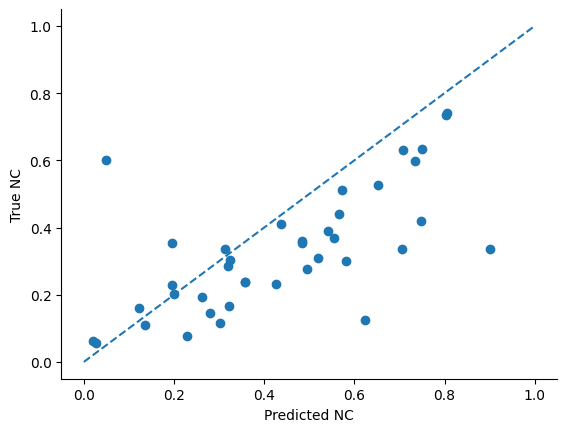

In [98]:
plt.scatter(nc_ratio_test_pred,nc_ratio_test_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

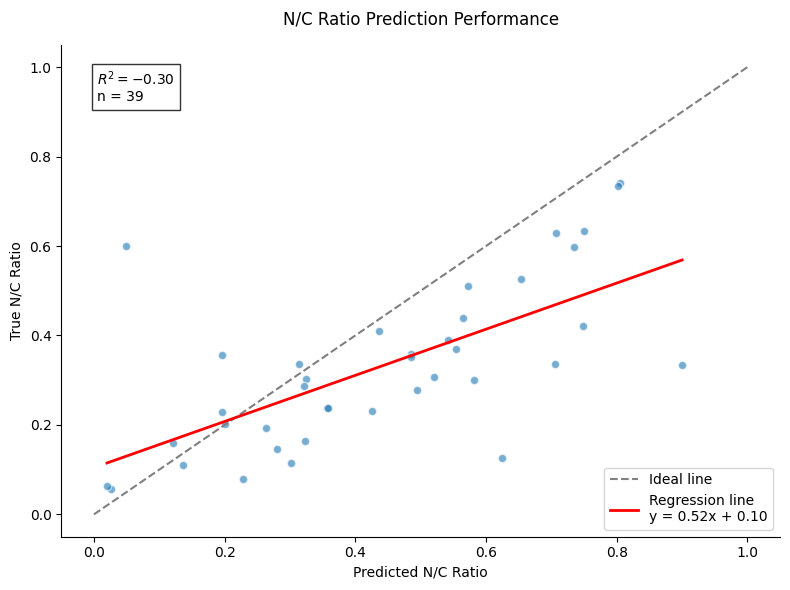

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


plt.figure(figsize=(8, 6))
plt.scatter(nc_ratio_test_pred, nc_ratio_test_true, alpha=0.6, edgecolor='w')

reg = LinearRegression().fit(nc_ratio_test_pred.reshape(-1, 1), nc_ratio_test_true)
slope = reg.coef_[0]
intercept = reg.intercept_
r2 = r2_score(nc_ratio_test_true, nc_ratio_test_pred)

x_range = np.linspace(min(nc_ratio_test_pred), max(nc_ratio_test_pred), 100)
y_reg = reg.predict(x_range.reshape(-1, 1))

plt.plot([0, 1], [0, 1], ls="--", c='gray', label='Ideal line')  
plt.plot(x_range, y_reg, c='red', lw=2, 
         label=f'Regression line\ny = {slope:.2f}x + {intercept:.2f}')

plt.text(0.05, 0.95, 
         f'$R^2 = {r2:.2f}$\nn = {len(nc_ratio_test_true)}', 
         transform=plt.gca().transAxes,
         ha='left', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel("Predicted N/C Ratio")
plt.ylabel("True N/C Ratio")
plt.title("N/C Ratio Prediction Performance", pad=15)
plt.legend(loc='lower right', frameon=True)
sns.despine()

plt.tight_layout()
plt.show()

In [100]:
# Import necessary metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


def calculate_metrics(y_true, y_pred, threshold=0.5):

    # Binarize predictions based on the threshold
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_true_binary = (y_true >= threshold).astype(int)
    
    metrics = {
        "F1 Score": f1_score(y_true_binary, y_pred_binary, average='binary'),
        "Accuracy": accuracy_score(y_true_binary, y_pred_binary),
        "Precision": precision_score(y_true_binary, y_pred_binary, average='binary'),
        "Recall": recall_score(y_true_binary, y_pred_binary, average='binary')
    }
    return metrics




In [101]:
metrics_1 = calculate_metrics(nc_ratio_test_true, nc_ratio_test_pred)

# Print the calculated metrics
print("Performance Metrics:")
for metric, value in metrics_1.items():
    print(f"{metric}: {value:.4f}")

Performance Metrics:
F1 Score: 0.5833
Accuracy: 0.7436
Precision: 0.4375
Recall: 0.8750


## Advanced Approach: Optimize Thresholds

In [102]:
# Comment out and install scikit-optimize if you don't have it
# ! pip install scikit-optimize

In [103]:
from scipy.optimize import minimize
from skopt import gp_minimize
from skopt.space import Real

metric_dict=dict(spearman=lambda x,y: spearmanr(x,y,nan_policy="omit")[0],
                mae=lambda x,y: -np.abs(x-y).mean())

def loss_func(thresholds,metric="spearman"):
    thresholds=sorted(thresholds)
    nc_ratio_train_pred=np.vectorize(lambda x: calc_nc_ratio(x,*thresholds),signature='(w,h)->()')(X_train_gray)
    stat=metric_dict[metric](nc_ratio_train_pred,nc_ratio_train_true)
    if np.isnan(stat) and metric=="spearman": return 0
    elif np.isnan(stat) and metric=="mae": return 1
    return -stat


space = [
    Real(0, 1, name='threshold1'),
    Real(0, 1, name='threshold2')
]

metric="mae"
# Perform the optimization
res = gp_minimize(lambda x: loss_func(x,metric=metric), space, x0=(0.4,0.6), n_calls=30, acq_optimizer="lbfgs", random_state=0, n_jobs=-1, verbose=False)

C:\Users\JOKER\AppData\Local\Temp\ipykernel_11672\463714545.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return nucleus_area/(nucleus_area+cytoplasm_area)


In [104]:
final_thresholds=sorted(res.x_iters[res.func_vals.argmin()])
pd.to_pickle(final_thresholds,"final_thresholds.pkl")

In [105]:
nc_ratio_test_pred=np.vectorize(lambda x: calc_nc_ratio(x,*final_thresholds),signature='(w,h)->()')(X_test_gray)
spearmanr(nc_ratio_test_pred,nc_ratio_test_true,nan_policy="omit")[0],np.abs(nc_ratio_test_pred-nc_ratio_test_true).mean()

(np.float64(0.6530364372469636), np.float64(0.11829178573501167))

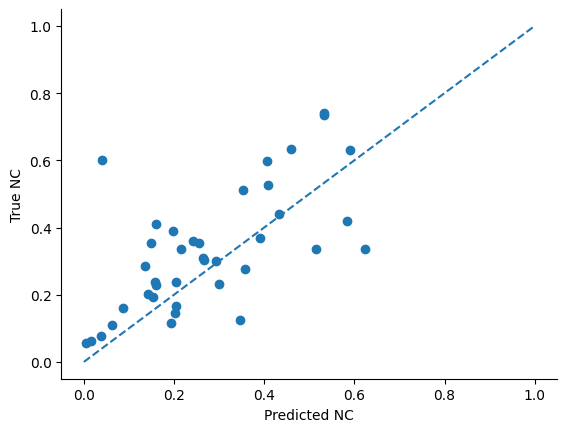

In [106]:
plt.scatter(nc_ratio_test_pred,nc_ratio_test_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

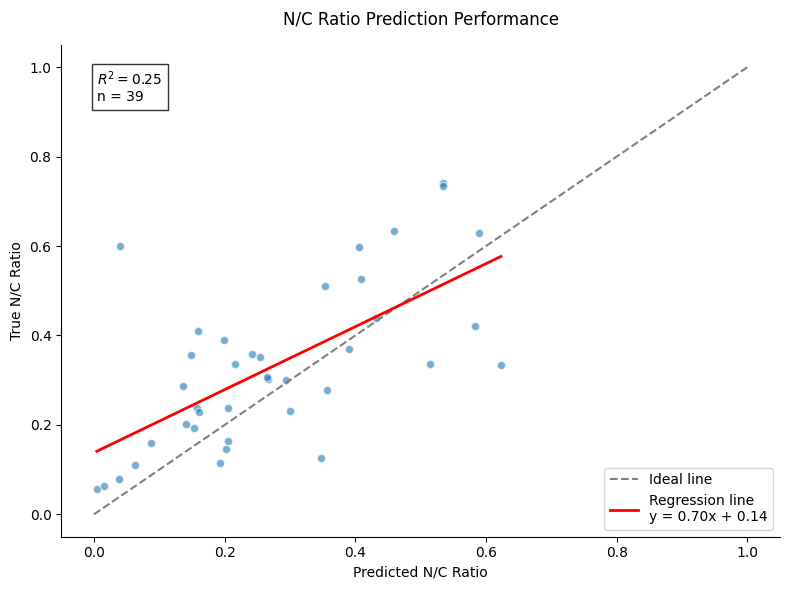

In [107]:

plt.figure(figsize=(8, 6))
plt.scatter(nc_ratio_test_pred, nc_ratio_test_true, alpha=0.6, edgecolor='w')

reg = LinearRegression().fit(nc_ratio_test_pred.reshape(-1, 1), nc_ratio_test_true)
slope = reg.coef_[0]
intercept = reg.intercept_
r2 = r2_score(nc_ratio_test_true, nc_ratio_test_pred)

x_range = np.linspace(min(nc_ratio_test_pred), max(nc_ratio_test_pred), 100)
y_reg = reg.predict(x_range.reshape(-1, 1))

plt.plot([0, 1], [0, 1], ls="--", c='gray', label='Ideal line')  
plt.plot(x_range, y_reg, c='red', lw=2, 
         label=f'Regression line\ny = {slope:.2f}x + {intercept:.2f}')

plt.text(0.05, 0.95, 
         f'$R^2 = {r2:.2f}$\nn = {len(nc_ratio_test_true)}', 
         transform=plt.gca().transAxes,
         ha='left', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel("Predicted N/C Ratio")
plt.ylabel("True N/C Ratio")
plt.title("N/C Ratio Prediction Performance", pad=15)
plt.legend(loc='lower right', frameon=True)
sns.despine()

plt.tight_layout()
plt.show()

# Report segmentation model performance

In [108]:

metrics_2 = calculate_metrics(nc_ratio_test_true, nc_ratio_test_pred)

# Print the calculated metrics
print("Performance Metrics:")
for metric, value in metrics_2.items():
    print(f"{metric}: {value:.4f}")

Performance Metrics:
F1 Score: 0.4286
Accuracy: 0.7949
Precision: 0.5000
Recall: 0.3750
